# IMPORTING FILES AND PACKAGES

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
import re

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# EXPLORING AND UNDERSTANDING THE DATA SET

In [50]:
# Naming and creating the dataframe with data from the imported file
df = pd.read_csv("retail_data.csv")

In [51]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 8:26,3.39,17850.0,United Kingdom


In [52]:
# Obtaining the general information of the dataframe to get familiarized with it 
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [53]:
# Checking amount of null values in every variable
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [54]:
# Checking the ratio of null values present in every variable
pd.DataFrame(data = [df.isna().sum()/df.shape[0]*100],
             index=["Null (%)"]).T.style.background_gradient(cmap='summer_r')

,Null (%)
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


In [55]:
# Checking type of data in all columns
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [56]:
Checking the distribution for all the variables together
trace1 = go.Box(x=df['Quantity'],name='Quantity')
trace2 = go.Box(x=df['UnitPrice'], name='UnitPrice')

fig = make_subplots(rows=2, cols=1)
fig.append_trace(trace1, row = 1, col = 1)
fig.append_trace(trace2, row = 2, col = 1)

fig.update_layout(
    autosize=True,
    title_text = 'Distribution of each variable',
    title_x=0.5,
    title_font_size=20)

fig.show()

In [57]:
(df['Quantity'] < 0).sum()

10624

In [58]:
(df['UnitPrice'] < 0).sum()

2

In [59]:
# Obtaining size and count of values in each variable 
df.agg(['size', 'count', 'nunique'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
size,541909,541909,541909,541909,541909,541909,541909,541909
count,541909,541909,540455,541909,541909,541909,406829,541909
nunique,25900,4070,4211,722,23260,1630,4372,38


In [60]:
# Count of observations per Country --> most of the observations are in the United kingdom
df['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

# DATA TRANSFORMATION

In [61]:
# Converting the InvoiceDate to datetime format 
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)

In [62]:
# Dropping na values of variable Costumer ID in dataframe, since it is not possible to retrieve these codes from the other columns
df = df.dropna(axis=0, subset=['CustomerID'])

In [63]:
# Checking amount of observations that have a negative quantity 
((df['Quantity'] < 0) & (df['Description'] == 'Discount')).sum() 

77

In [64]:
# Amount of negative values in variable Quantity after dropping NAs 
(df['Quantity'] < 0).sum()

8905

In [65]:
# Amount of negative values in variable Unit Price after dropping NAs 
(df['UnitPrice'] <= 0).sum()

40

In [67]:
# We create a new variable that represents the total price of each Invoice
df['TotalPrice'] = df['Quantity']*df['UnitPrice']

# DATA PREPARATION FOR CLUSTERING

## Recency 

Calculating the Recency by retrieving the number of days between the date of the invoice and the date of the last purchase for each customer





In [68]:
# first we need to create a new simplified date variable only with day-month-year information 
df['Date'] = pd.DatetimeIndex(df.InvoiceDate).date

# We will also need the last date available
print( 'Last date available:', df['InvoiceDate'].max())
Now = dt.date(2011,12,10)

# We create a new dataframe where we will store the recency value for each Costumer ID
df_R = df.groupby(['CustomerID'],as_index=False)['Date'].max()

# Creating recency column 
df_R['Recency'] = df_R.Date.apply(lambda x:(Now - x).days)

# Dropping the date of last purchase since it is no longer needed
df_R.drop(columns=['Date'],inplace=True)

Last date available: 2011-12-10 17:19:00


In [69]:
print( 'Last date available:', df['InvoiceDate'].min())

Last date available: 2010-01-12 08:26:00


In [70]:
df_R.reset_index()
df_R.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,40
2,12348.0,76
3,12349.0,19
4,12350.0,311


## Frecuency

For Frequency we calculate the number of orders for each customer per month 

In [71]:
# Creating new variable Month 
df['Month'] = pd.DatetimeIndex(df['Date']).month

# First we aggregate by costumer the amount of invoices they had 
df_F = df.groupby(['CustomerID','Month']).agg({'InvoiceNo' : lambda x:len(x)})

# Renaming frequency column
df_F.rename(columns = {'InvoiceNo' :'Frequency'},inplace= True)

# Restting the index 
df_F = df_F.reset_index()

# Grouping by mean Frequency per month
df_F = df_F.groupby(['CustomerID'],as_index=False)['Frequency'].mean()

In [72]:
df_F

,CustomerID,Frequency
0,12346.0,2.000000
1,12347.0,36.400000
2,12348.0,7.750000
3,12349.0,73.000000
4,12350.0,17.000000
...,...,...
4367,18280.0,10.000000
4368,18281.0,7.000000
4369,18282.0,4.333333
4370,18283.0,94.500000


## Monetary

For Monetary we calculate the average value of ticket for each customer.

In [73]:
# calculating the average value of invoices
df_M = df.groupby('CustomerID').agg({'TotalPrice': lambda x:x.mean()})

# Renaming the columns
df_M.rename(columns = {'TotalPrice':'MonetaryValue'},inplace= True) 

In [74]:
df_M

,MonetaryValue
CustomerID,
12346.0,0.000000
12347.0,23.681319
12348.0,57.975484
12349.0,24.076027
12350.0,19.670588
...,...
18280.0,18.060000
18281.0,11.545714
18282.0,13.584615


## RFM Table 

In [75]:
df_RFM = df_R.merge(df_F,left_on='CustomerID',right_on='CustomerID')
df_RFM = df_RFM.merge(df_M,left_on='CustomerID',right_on='CustomerID')
df_RFM_not_stand = df_RFM.copy()

## Data Exploration

Recency's: Skew: -0.6196370975360853, : SkewtestResult(statistic=-15.393161235305994, pvalue=1.819227845118319e-53)
Frequency's: Skew: -0.19958697121540722, : SkewtestResult(statistic=-5.319699845859913, pvalue=1.0393858586238234e-07)
MonetaryValue's: Skew: 0.9953218915529441, : SkewtestResult(statistic=22.6063807137198, pvalue=3.750616361280559e-113)


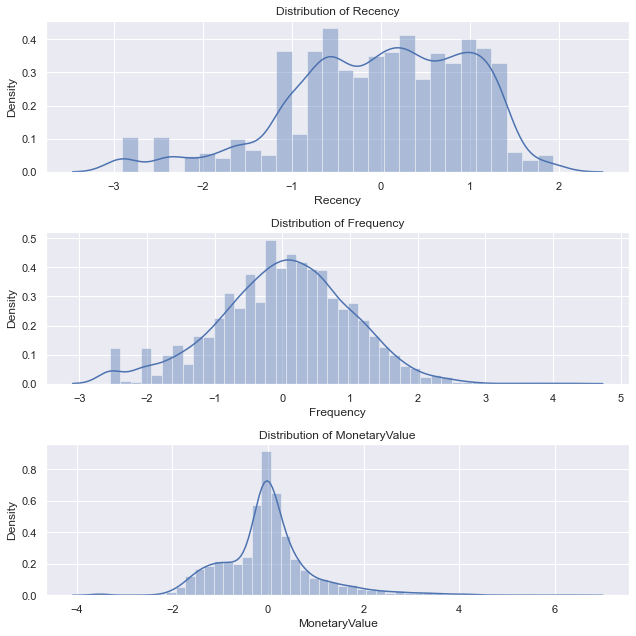

In [106]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return


# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_RFM,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_RFM,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_RFM,'MonetaryValue')

plt.tight_layout()
plt.savefig('before_transform.png', format='png', dpi=1000)

In [ ]:
# We will perform the following transformations to the data to make it easier to work with and retrieve insights
# First we will do a log trasformation to solve for skweness and then standarize it to use the same scale in all of them

Recency's: Skew: -0.6156928697695474, : SkewtestResult(statistic=-15.380415140672259, pvalue=2.2152275580132432e-53)
Frequency's: Skew: -0.22948199664039667, : SkewtestResult(statistic=-6.126651125652808, pvalue=8.974796102459322e-10)
MonetaryValue's: Skew: nan, : SkewtestResult(statistic=nan, pvalue=nan)


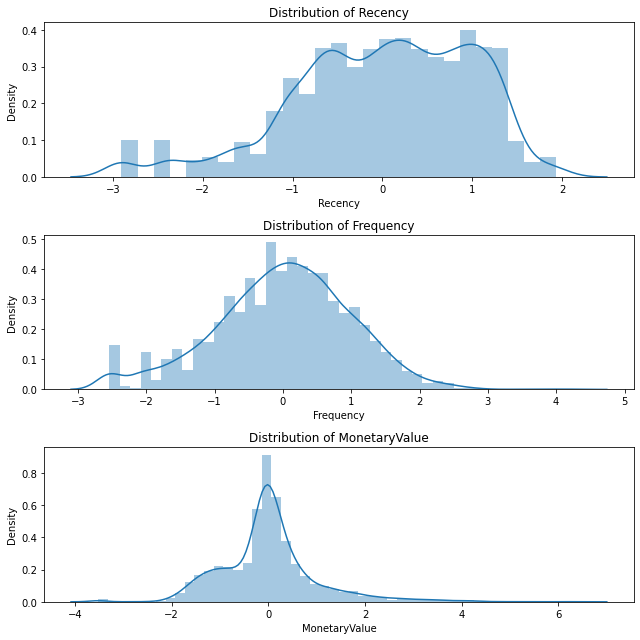

In [77]:
df_RFM_ID = df_RFM.copy()
feature_cols = ['Recency', 'Frequency', 'MonetaryValue']

df_RFM = np.log(df_RFM[feature_cols]+1)

scaler = StandardScaler()

df_RFM = df_RFM.copy()

scaler = StandardScaler()
scaler.fit(df_RFM[feature_cols])
standardized_features = scaler.transform(df_RFM[feature_cols])
df_RFM[feature_cols] = standardized_features


plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_RFM,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_RFM,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_RFM, 'MonetaryValue')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)


In [78]:
#df_RFM.isnull().sum()
df_RFM = df_RFM[df_RFM['MonetaryValue'].notna()]
df_RFM_ID = df_RFM_ID[df_RFM_ID['MonetaryValue'].notna()]

## KMeans Clustering

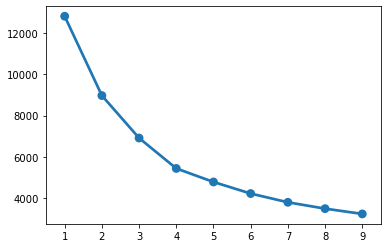

In [79]:
SSE = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=777).fit(df_RFM[feature_cols])
    SSE.append(kmeans.inertia_)

sns.pointplot(x=list(range(1,10)), y=SSE)

plt.show()

In [80]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(df_RFM)
df_RFM['cluster'] = kmeanModel.predict(df_RFM)

import plotly.graph_objects as go

PLOT = go.Figure()

for C in list(df_RFM.cluster.unique()):
    
    PLOT.add_trace(go.Scatter3d(x = df_RFM[df_RFM.cluster == C]['Frequency'],
                                y = df_RFM[df_RFM.cluster == C]['Recency'],
                                z = df_RFM[df_RFM.cluster == C]['MonetaryValue'],
                                mode = 'markers', marker_size = 8, marker_line_width = 1,
                                name = 'Cluster ' + str(C)))


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Frequency', titlefont_color = 'black'),
                                yaxis=dict(title = 'Recency', titlefont_color = 'black'),
                                zaxis=dict(title = 'MonetaryValue', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))




In [81]:
df_RFM

,Recency,Frequency,MonetaryValue,cluster
0,1.376105,-2.081396,-3.521360,2
1,-0.159463,0.791142,0.344573,0
2,0.306618,-0.862683,1.394938,1
3,-0.690333,1.568058,0.363704,0
4,1.341379,-0.041452,0.130738,2
...,...,...,...,...
4367,0.852101,-0.602144,0.032922,2
4368,-1.715551,-0.964708,-0.471370,0
4369,0.454148,-1.426335,-0.289787,2
4370,-1.132457,1.858448,-1.920818,3


In [82]:
df_RFM_cluster = pd.merge(df_RFM, df_RFM_ID, left_index=True, right_index=True)
df_RFM_cluster = df_RFM_cluster[df_RFM_cluster['MonetaryValue_x'].notna()]
df_RFM_cluster.drop(columns=['Recency_x', 'Frequency_x', 'MonetaryValue_x'],axis=1, inplace=True)

In [83]:
results = pd.merge(df, df_RFM_cluster, left_on='CustomerID', right_on='CustomerID')

In [84]:
#results

### Business questions

How many groups of customers do we have

In [85]:
# list(results['cluster'].unique())

In [86]:
# #define data
# data = results.groupby('CustomerID')
# labels = results['cluster'].unique()

# #define Seaborn color palette to use
# colors = sns.color_palette('pastel')[0:5]

# #create pie chart
# plt.pie(data, labels = list(results['cluster'].unique()), colors = colors, autopct='%.0f%%')
# plt.show()

<AxesSubplot:xlabel='cluster', ylabel='count'>

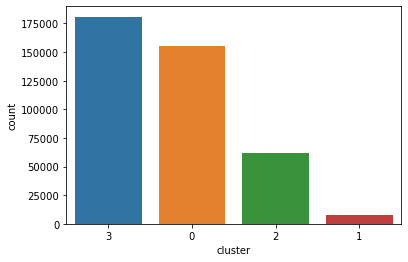

In [87]:
sns.countplot(x=results["cluster"],order = results["cluster"].value_counts().index)

Lets analyse consumptions behaviour of each cluster

Feature: Recency

Cluster 3
Mean: 52.5


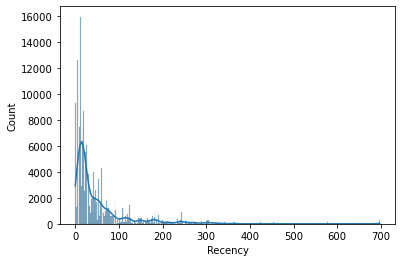

Cluster 0
Mean: 11.32


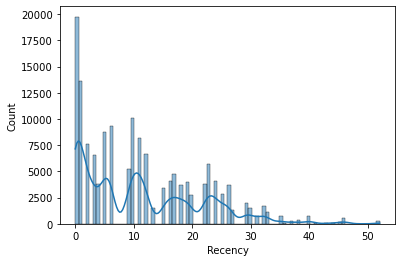

Cluster 2
Mean: 121.76


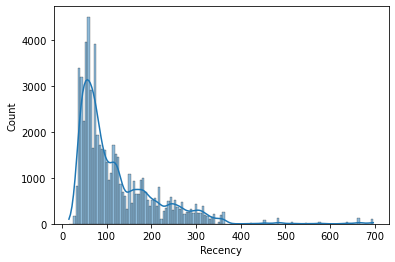

Cluster 1
Mean: 47.03


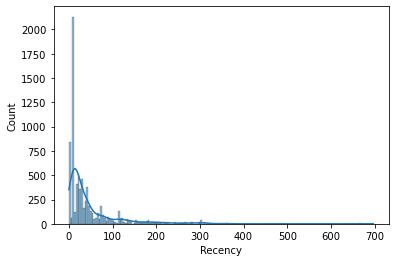

In [88]:
print("Feature: Recency\n")
mean = []
cluster = []
for x in list(results['cluster'].unique()):
    num_var = results[results['cluster'] == x ]['Recency_y']
    mean.append(round(num_var.mean(),2))
    cluster.append(x)
    print("Cluster {0}".format(x))
    print("Mean: {0}".format(round(num_var.mean(),2)))
    num_var = pd.Series(num_var, name = "Recency")
    # Plot histogram
    sns.histplot(data = num_var, kde = True)
    plt.show()

In [89]:
# Create the pandas DataFrame with column name is provided explicitly
Recency = pd.DataFrame()
Recency['Cluster'] = cluster
Recency['Recency Mean'] = mean
Recency

,Cluster,Recency Mean
0,3,52.50
1,0,11.32
2,2,121.76
3,1,47.03


In terms of Recency, customers from Cluster 0 is the one that bought more recent as it mean is 11.32 days from their last purchase. 
On the other hand, customers from Cluster 3 and 1 are pretty similar, as they are bouth near 50 days on average from thei last bought. 
Finally, customers from Cluster 2 seems to be people that stop buying for a long time as it has 121 days on average from their last bought.

Feature: Frequency

Cluster 3
Mean: 128.04


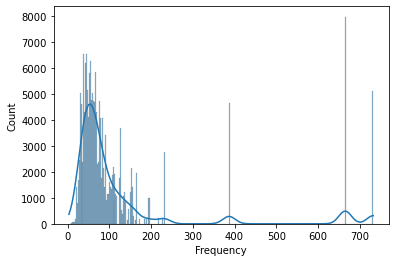

Cluster 0
Mean: 58.91


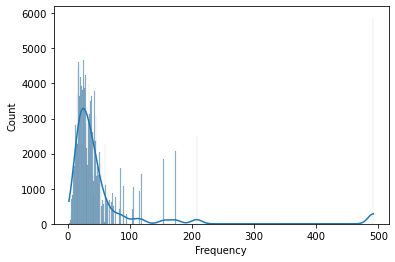

Cluster 2
Mean: 20.46


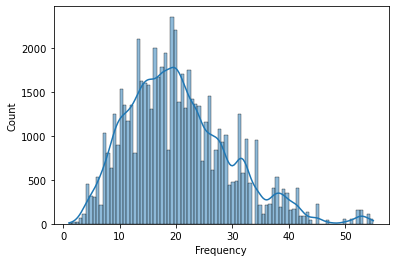

Cluster 1
Mean: 12.88


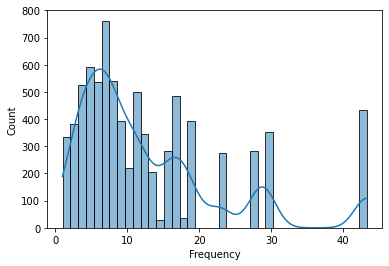

In [90]:
print("Feature: Frequency\n")
mean = []
cluster = []
for x in list(results['cluster'].unique()):
    num_var = results[results['cluster'] == x ]['Frequency_y']
    mean.append(round(num_var.mean(),2))
    cluster.append(x)
    print("Cluster {0}".format(x))
    print("Mean: {0}".format(round(num_var.mean(),2)))
    num_var = pd.Series(num_var, name = "Frequency")
    # Plot histogram
    sns.histplot(data = num_var, kde = True)
    plt.show()

In [91]:
# Create the pandas DataFrame with column name is provided explicitly
Frequency = pd.DataFrame()
Frequency['Cluster'] = cluster
Frequency['Frequency Mean'] = mean
Frequency

,Cluster,Frequency Mean
0,3,128.04
1,0,58.91
2,2,20.46
3,1,12.88


In terms of Frequency, customers from Cluster 3 is the one that buy more frequent with an average of 128 purchases per month. 
On the other hand, customers from Cluster 0 and 2 follows with 59 and 20 purchases per month on average. 
Finally, customers from Cluster 1 seems to be people that buy less times per month with an average of 13 purchases per month.

Feature: Monetary Value

Cluster 3
Mean: 8.19


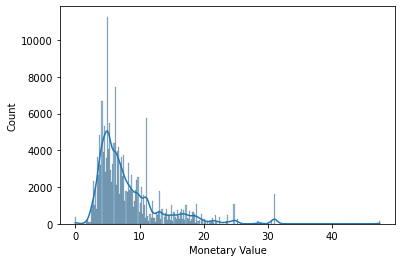

Cluster 0
Mean: 26.43


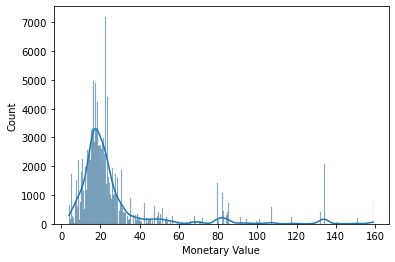

Cluster 2
Mean: 20.01


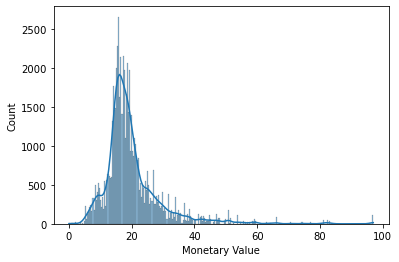

Cluster 1
Mean: 186.56


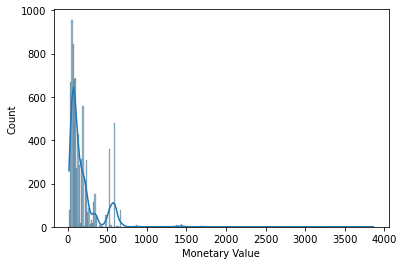

In [92]:
print("Feature: Monetary Value\n")
mean = []
cluster = []
for x in list(results['cluster'].unique()):
    num_var = results[results['cluster'] == x ]['MonetaryValue_y']
    mean.append(round(num_var.mean(),2))
    cluster.append(x)
    print("Cluster {0}".format(x))
    print("Mean: {0}".format(round(num_var.mean(),2)))
    num_var = pd.Series(num_var, name = "Monetary Value")
    # Plot histogram
    sns.histplot(data = num_var, kde = True)
    plt.show()

In [93]:
# Create the pandas DataFrame with column name is provided explicitly
Monetary_Value = pd.DataFrame()
Monetary_Value['Cluster'] = cluster
Monetary_Value['Monetary Value Mean'] = mean
Monetary_Value

,Cluster,Monetary Value Mean
0,3,8.19
1,0,26.43
2,2,20.01
3,1,186.56


In terms of Monetary Value, customers from Cluster 1 are the ones that buy the most expensives products with an average of 186 dollars per purchase. 
On the other hand, customers from Cluster 0 and 2 follows with 26 and 20 dollars per purchase on average. 
Finally, customers from Cluster 3 seems to be people that buy less expensive products with an average of 8 dollars per purchase.

Let's see how much money each Cluster "leave" on the store

In [94]:
Money = results.groupby(['cluster'],as_index=False)['MonetaryValue_y'].sum().sort_values('MonetaryValue_y')
Money

,cluster,MonetaryValue_y
2,2,1244727.953
1,1,1474043.420
3,3,1481806.700
0,0,4112716.881


<AxesSubplot:>

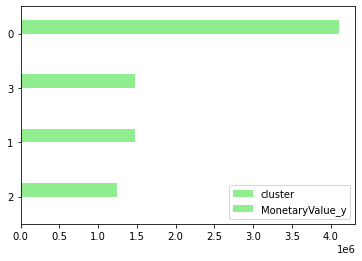

In [95]:
Money.plot(kind='barh', color='lightgreen')

To conclude consumers behaviours, we can see that customers from Cluster 0 spent the higher amount of money, 4 million dollars, followed by Cluster 3 and 1 with 1.47 million and last Cluster 2 with 1.25 million. 
To sum up, potentially customers from Cluster 0 are the most valuable and consistent, as they expend the higher amount, with a consistent frequency compare to the other Clusters and with the more recent purchases.  

Let's see some of the most important characteristic of this Cluster:

[Text(0, 0, 'United Kingdom'),
 Text(1, 0, 'Netherlands'),
 Text(2, 0, 'Germany'),
 Text(3, 0, 'France'),
 Text(4, 0, 'Spain'),
 Text(5, 0, 'Portugal'),
 Text(6, 0, 'Italy'),
 Text(7, 0, 'Lithuania'),
 Text(8, 0, 'Japan'),
 Text(9, 0, 'Australia'),
 Text(10, 0, 'Channel Islands'),
 Text(11, 0, 'Cyprus'),
 Text(12, 0, 'Finland'),
 Text(13, 0, 'EIRE'),
 Text(14, 0, 'Switzerland'),
 Text(15, 0, 'Belgium'),
 Text(16, 0, 'Greece'),
 Text(17, 0, 'Lebanon'),
 Text(18, 0, 'Austria'),
 Text(19, 0, 'Norway'),
 Text(20, 0, 'Poland'),
 Text(21, 0, 'United Arab Emirates'),
 Text(22, 0, 'Israel'),
 Text(23, 0, 'Saudi Arabia'),
 Text(24, 0, 'Canada'),
 Text(25, 0, 'Denmark'),
 Text(26, 0, 'Unspecified'),
 Text(27, 0, 'Brazil'),
 Text(28, 0, 'Sweden'),
 Text(29, 0, 'USA'),
 Text(30, 0, 'European Community'),
 Text(31, 0, 'Bahrain'),
 Text(32, 0, 'Malta'),
 Text(33, 0, 'RSA')]

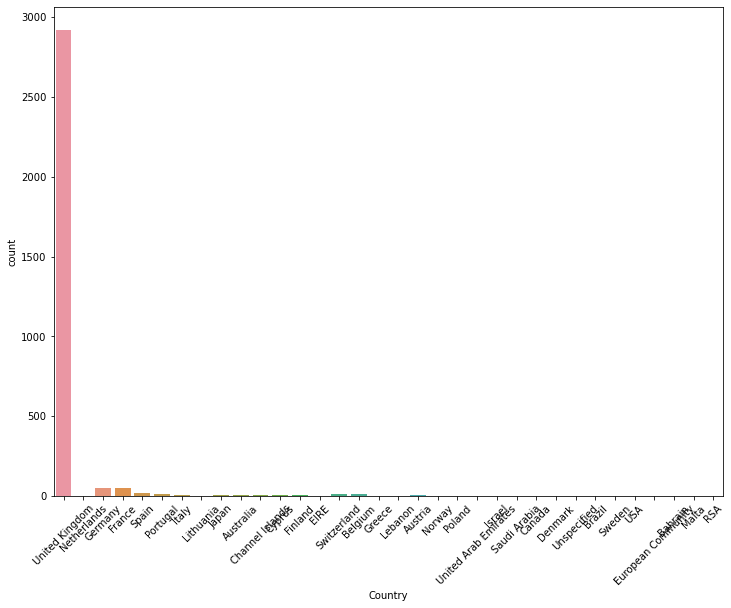

In [96]:
cluster_0 = results.mask(results['cluster'] == 0)
country = cluster_0.drop_duplicates(subset = ['CustomerID'], keep='first')
f, ax = plt.subplots(figsize=(12, 9))
sns.countplot(x=country['Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

As we can see in the graph above, almost all customers belong to United Kingdom. Let's see now other cluster's geographical distribution:

Cluster 1: 


[Text(0, 0, 'United Kingdom'),
 Text(1, 0, 'France'),
 Text(2, 0, 'Australia'),
 Text(3, 0, 'Germany'),
 Text(4, 0, 'Norway'),
 Text(5, 0, 'EIRE'),
 Text(6, 0, 'Switzerland'),
 Text(7, 0, 'Poland'),
 Text(8, 0, 'Portugal'),
 Text(9, 0, 'Italy'),
 Text(10, 0, 'Belgium'),
 Text(11, 0, 'Lithuania'),
 Text(12, 0, 'Japan'),
 Text(13, 0, 'Iceland'),
 Text(14, 0, 'Channel Islands'),
 Text(15, 0, 'Denmark'),
 Text(16, 0, 'Spain'),
 Text(17, 0, 'Cyprus'),
 Text(18, 0, 'Sweden'),
 Text(19, 0, 'Austria'),
 Text(20, 0, 'Netherlands'),
 Text(21, 0, 'Finland'),
 Text(22, 0, 'Greece'),
 Text(23, 0, 'Singapore'),
 Text(24, 0, 'Lebanon'),
 Text(25, 0, 'United Arab Emirates'),
 Text(26, 0, 'Israel'),
 Text(27, 0, 'Saudi Arabia'),
 Text(28, 0, 'Czech Republic'),
 Text(29, 0, 'Canada'),
 Text(30, 0, 'Unspecified'),
 Text(31, 0, 'Brazil'),
 Text(32, 0, 'USA'),
 Text(33, 0, 'European Community'),
 Text(34, 0, 'Bahrain'),
 Text(35, 0, 'Malta'),
 Text(36, 0, 'RSA')]

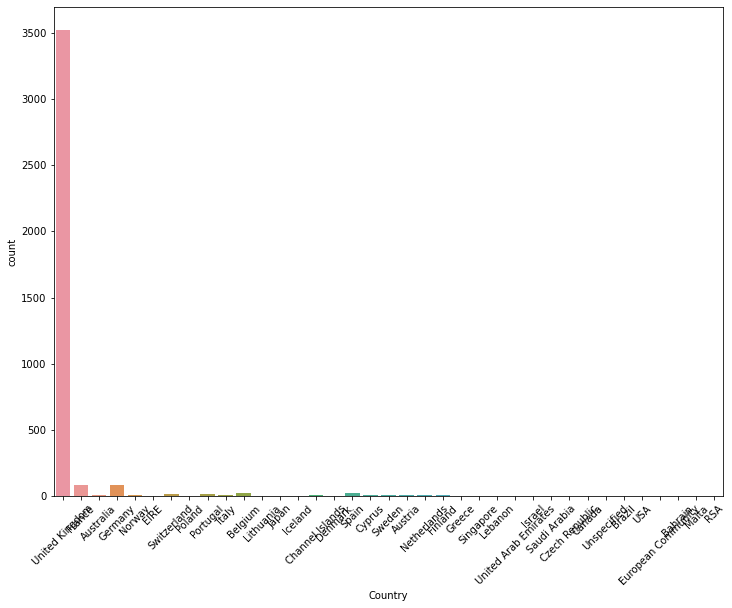

In [97]:
print("Cluster 1: ")
cluster_1 = results.mask(results['cluster'] == 1)
country = cluster_1.drop_duplicates(subset = ['CustomerID'], keep='first')
f, ax = plt.subplots(figsize=(12, 9))
sns.countplot(x=country['Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

Cluster 2: 


[Text(0, 0, 'United Kingdom'),
 Text(1, 0, 'France'),
 Text(2, 0, 'Australia'),
 Text(3, 0, 'Netherlands'),
 Text(4, 0, 'Germany'),
 Text(5, 0, 'Norway'),
 Text(6, 0, 'EIRE'),
 Text(7, 0, 'Switzerland'),
 Text(8, 0, 'Spain'),
 Text(9, 0, 'Poland'),
 Text(10, 0, 'Belgium'),
 Text(11, 0, 'Italy'),
 Text(12, 0, 'Iceland'),
 Text(13, 0, 'Portugal'),
 Text(14, 0, 'Japan'),
 Text(15, 0, 'Denmark'),
 Text(16, 0, 'Cyprus'),
 Text(17, 0, 'Sweden'),
 Text(18, 0, 'Austria'),
 Text(19, 0, 'Finland'),
 Text(20, 0, 'Singapore'),
 Text(21, 0, 'Channel Islands'),
 Text(22, 0, 'Czech Republic'),
 Text(23, 0, 'Greece'),
 Text(24, 0, 'Canada'),
 Text(25, 0, 'Malta'),
 Text(26, 0, 'Unspecified'),
 Text(27, 0, 'Israel'),
 Text(28, 0, 'USA'),
 Text(29, 0, 'RSA')]

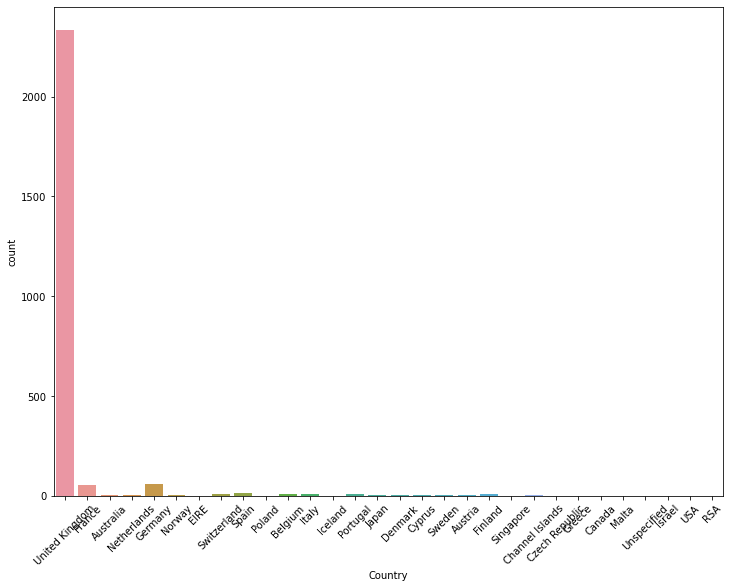

In [98]:
print("Cluster 2: ")
cluster_2 = results.mask(results['cluster'] == 2)
country = cluster_2.drop_duplicates(subset = ['CustomerID'], keep='first')
f, ax = plt.subplots(figsize=(12, 9))
sns.countplot(x=country['Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

Cluster 3: 


[Text(0, 0, 'France'),
 Text(1, 0, 'United Kingdom'),
 Text(2, 0, 'Australia'),
 Text(3, 0, 'Netherlands'),
 Text(4, 0, 'Germany'),
 Text(5, 0, 'Norway'),
 Text(6, 0, 'EIRE'),
 Text(7, 0, 'Switzerland'),
 Text(8, 0, 'Spain'),
 Text(9, 0, 'Poland'),
 Text(10, 0, 'Portugal'),
 Text(11, 0, 'Italy'),
 Text(12, 0, 'Belgium'),
 Text(13, 0, 'Lithuania'),
 Text(14, 0, 'Japan'),
 Text(15, 0, 'Iceland'),
 Text(16, 0, 'Channel Islands'),
 Text(17, 0, 'Denmark'),
 Text(18, 0, 'Sweden'),
 Text(19, 0, 'Austria'),
 Text(20, 0, 'Finland'),
 Text(21, 0, 'Cyprus'),
 Text(22, 0, 'Greece'),
 Text(23, 0, 'Singapore'),
 Text(24, 0, 'Lebanon'),
 Text(25, 0, 'United Arab Emirates'),
 Text(26, 0, 'Israel'),
 Text(27, 0, 'Saudi Arabia'),
 Text(28, 0, 'Czech Republic'),
 Text(29, 0, 'Canada'),
 Text(30, 0, 'Unspecified'),
 Text(31, 0, 'Brazil'),
 Text(32, 0, 'USA'),
 Text(33, 0, 'European Community'),
 Text(34, 0, 'Bahrain'),
 Text(35, 0, 'Malta')]

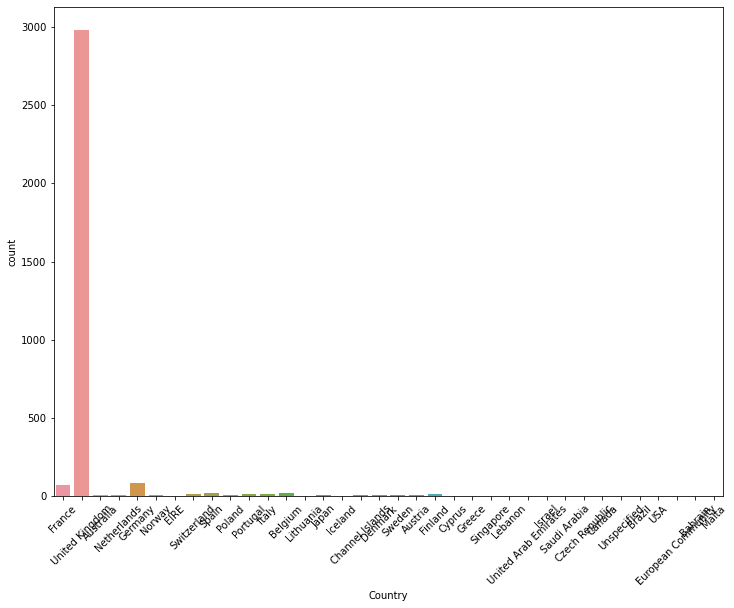

In [100]:
print("Cluster 3: ")
cluster_3 = results.mask(results['cluster'] == 3)
country = cluster_3.drop_duplicates(subset = ['CustomerID'], keep='first')
f, ax = plt.subplots(figsize=(12, 9))
sns.countplot(x=country['Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

Customers from other clusters also are mainly from United Kingdom. Let's see consumption trend now:

(array([14610., 14700., 14791., 14883., 14975., 15065., 15156., 15248.,
        15340.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

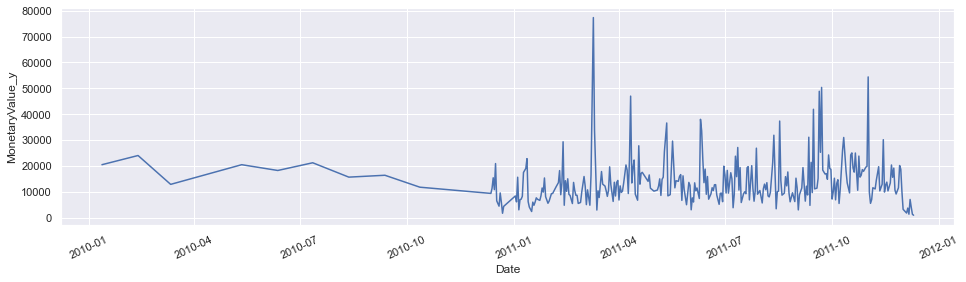

In [101]:
# create the time series plot
consumption_in_time = cluster_0.groupby(['Date'],as_index=False)['MonetaryValue_y'].sum()
# create the time series plot
sns.set(rc={"figure.figsize":(16, 4)}) #width=8, height=4
sns.lineplot(x = "Date", y = "MonetaryValue_y",
             data = consumption_in_time)  
plt.xticks(rotation = 25)

The trend we detect in terms of consumptions, is that customers from Cluster 0 are consistent in time, meaning there are no periods of time where they stop buying products from the store. In addition, we can see a smooth pattern from 2011 onwards with a cuple of peaks.  

Cluster 1: 


(array([14610., 14700., 14791., 14883., 14975., 15065., 15156., 15248.,
        15340.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

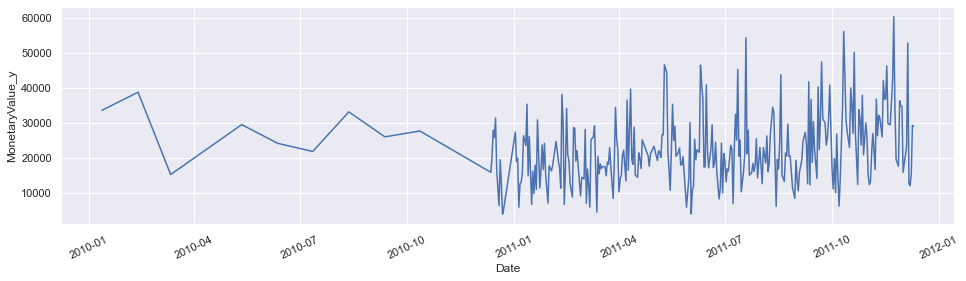

In [103]:
# create the time series plot
print("Cluster 1: ")
consumption_in_time = cluster_1.groupby(['Date'],as_index=False)['MonetaryValue_y'].sum()
# create the time series plot
sns.set(rc={"figure.figsize":(16, 4)}) #width=8, height=4
sns.lineplot(x = "Date", y = "MonetaryValue_y",
             data = consumption_in_time)  
plt.xticks(rotation = 25)
# create the time series plot


Cluster 2: 


(array([14610., 14700., 14791., 14883., 14975., 15065., 15156., 15248.,
        15340.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

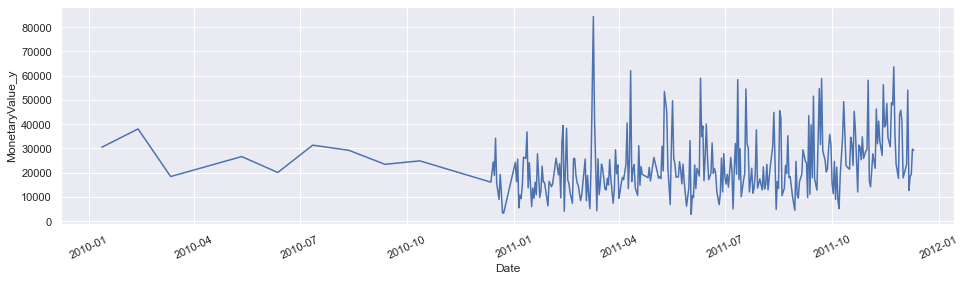

In [104]:
print("Cluster 2: ")
consumption_in_time = cluster_2.groupby(['Date'],as_index=False)['MonetaryValue_y'].sum()
# create the time series plot
sns.set(rc={"figure.figsize":(16, 4)}) #width=8, height=4
sns.lineplot(x = "Date", y = "MonetaryValue_y",
             data = consumption_in_time)  
plt.xticks(rotation = 25)


Cluster 3: 


(array([14610., 14700., 14791., 14883., 14975., 15065., 15156., 15248.,
        15340.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

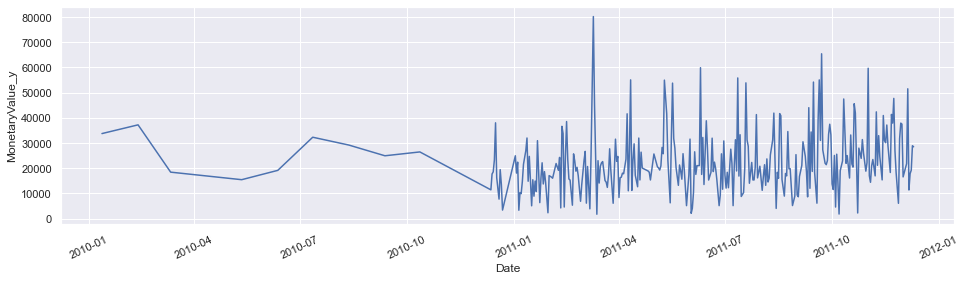

In [105]:
# create the time series plot
print("Cluster 3: ")
consumption_in_time = cluster_3.groupby(['Date'],as_index=False)['MonetaryValue_y'].sum()
# create the time series plot
sns.set(rc={"figure.figsize":(16, 4)}) #width=8, height=4
sns.lineplot(x = "Date", y = "MonetaryValue_y",
             data = consumption_in_time)  
plt.xticks(rotation = 25)

Other clusters seem to have same consumption pattern. 